1. Load thư viện

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from imutils import paths
import tensorflow as tf
from tensorflow.keras.applications import VGG16, imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

In [2]:
os.chdir("../input/image-flowers")
print(os.getcwd())

/kaggle/input/image-flowers


In [3]:
!ls

dataset


In [9]:
# !unzip dataset.zip -d Image

2. Load và xử lý dữ liệu

In [4]:
# Lấy các đường dẫn ảnh
image_path = list(paths.list_images('dataset/'))

# Xáo trộn ngẫu nhiên các đường dẫn ảnh
random.shuffle(image_path)

In [5]:
# Format đường dẫn: dataset/tên_loài_hoa/tên_ảnh/
# Ví dụ: dataset/Bluebell/image_0241.jpg
labels = [p.split(os.path.sep)[-2] for p in image_path]
print(f"Label category: {labels[:20]}....")

# Chuyển đổi label từ caterogy sang số
lb_encoder = LabelEncoder()
labels = lb_encoder.fit_transform(labels)
print(f"Labels after encoding: {labels[:20]}....")

# Chuyển đổi label từ số sang dạng one-hot encoding để dùng hàm loss "categories_crossentropy"
lb_binarizer = LabelBinarizer()
labels = lb_binarizer.fit_transform(labels)
print(f"Labels after one-hot encoding:\n {labels[:5]}....")

Label category: ['Windflower', 'Daffodil', 'Windflower', 'Snowdrop', 'Bluebell', 'Windflower', 'Daisy', 'Sunflower', 'Windflower', 'Buttercup', 'Tulip', 'LilyValley', 'ColtsFoot', 'Bluebell', 'Tulip', 'Iris', 'Dandelion', 'Tulip', 'Iris', 'Buttercup']....
Labels after encoding: [16  5 16 12  0 16  6 13 16  1 15 10  2  0 15  9  7 15  9  1]....
Labels after one-hot encoding:
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]....


In [6]:
list_image = []
with tqdm(total=len(image_path), unit='image', unit_scale=True, desc='Loading images') as pbar:
    for (_, path) in enumerate(image_path):
        image = load_img(path, target_size=(224, 224))
        image = img_to_array(image)

        image = np.expand_dims(image, axis=0)             # Mở rộng thêm 1 chiều (224, 224, 3) -> (1, 224, 224, 3)
        image = imagenet_utils.preprocess_input(image)    # Chuyển kênh màu RGB -> BGR và chuẩn hóa các giá trị pixels, mỗi pixels trừ đi [103.939, 116.779, 123.68]
        list_image.append(image)
        pbar.update(1)

list_image = np.vstack(list_image)  # Gộp một list thành mảng numpy lớn
print(list_image.shape)

Loading images: 100%|██████████| 1.36k/1.36k [00:08<00:00, 165image/s]


(1360, 224, 224, 3)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(list_image, labels, test_size=0.2, random_state=42)

3. Data Augmentation

In [8]:
# Data Augmentation cho tập train
# Các phép augment sẽ được thực hiện ngẫu nhiên giá trị, ex: horizonal_flip=True có xác suất 50% sẽ thực hiện phép lật ngang
aug_train = ImageDataGenerator(rescale=1./255,
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest'
                               )

# Data Augmentation cho tập test
aug_test = ImageDataGenerator(rescale=1./255)

4. Xây dựng model

In [9]:
baseModel = VGG16(weights='imagenet',
                  include_top=False,
                  input_tensor=Input(shape=(224, 224, 3)))

baseModel.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# X¥y th¶m c¡c layer
# L§y output cıa ConvNet trong VGG16
fcHead = baseModel.output

# Flatten trước khi dùng FCs
fcHead = Flatten(name='flatten')(fcHead)

# Thêm lớp FCs với hàm activation là ReLU
fcHead = Dense(256, activation='relu', name='dense_relu_layer')(fcHead)
fcHead = Dropout(0.5)(fcHead)

# Output layer với softmax activation
fcHead = Dense(17, activation='softmax', name='output_layer')(fcHead)

# X¥y dựng model bằng việc nối ConvNet của VGG16 và fcHead
model = Model(inputs=baseModel.input, outputs = fcHead)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_relu_layer (Dense)             │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,141,841 (80.65 MB)

 Trainable params: 21,141,841 (80.65 MB)

 Non-trainable params: 0 (0.00 B)

4. Training model

In [12]:
def create_infinite_generator(datagen, x, y, batch_size):   
    while True:  
        for x_batch, y_batch in datagen.flow(x, y, batch_size=batch_size):  
            yield x_batch, y_batch 

4.1. Freeze ConvNet Layers - VGG16 Model

In [13]:
# Freeze ConvNet Layers VGG16 Model
for layer in baseModel.layers:
    layer.trainable = False

model.compile(optimizer= RMSprop(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

numOfEpochs = 25
H = model.fit(x = create_infinite_generator(aug_train, X_train, y_train, 32),
              steps_per_epoch = len(X_train)//32,
              validation_data = create_infinite_generator(aug_test, X_train, y_train, 32),
              validation_steps = len(X_test)//32,
              epochs = numOfEpochs,
              verbose = 1)

Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 354ms/step - accuracy: 0.5073 - loss: 1.6194 - val_accuracy: 0.8203 - val_loss: 0.8691
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 318ms/step - accuracy: 0.6434 - loss: 1.2370 - val_accuracy: 0.8164 - val_loss: 0.7255
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 307ms/step - accuracy: 0.6678 - loss: 1.0500 - val_accuracy: 0.9336 - val_loss: 0.4659
Epoch 4/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 309ms/step - accuracy: 0.7145 - loss: 0.9317 - val_accuracy: 0.8828 - val_loss: 0.4849
Epoch 5/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 302ms/step - accuracy: 0.7323 - loss: 0.8682 - val_accuracy: 0.9375 - val_loss: 0.3405
Epoch 6/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 298ms/step - accuracy: 0.7660 - loss: 0.7411 - val_accuracy: 0.9375 - val_loss: 0.3368
Epoch 7/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 305ms/step - accuracy: 0.7898 - loss: 0.7292 - val_accuracy: 0.9688 - val_loss: 0.2297
Epoch 8/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 295ms/step - accuracy: 0.8098 - loss: 0.6129 - val_accu

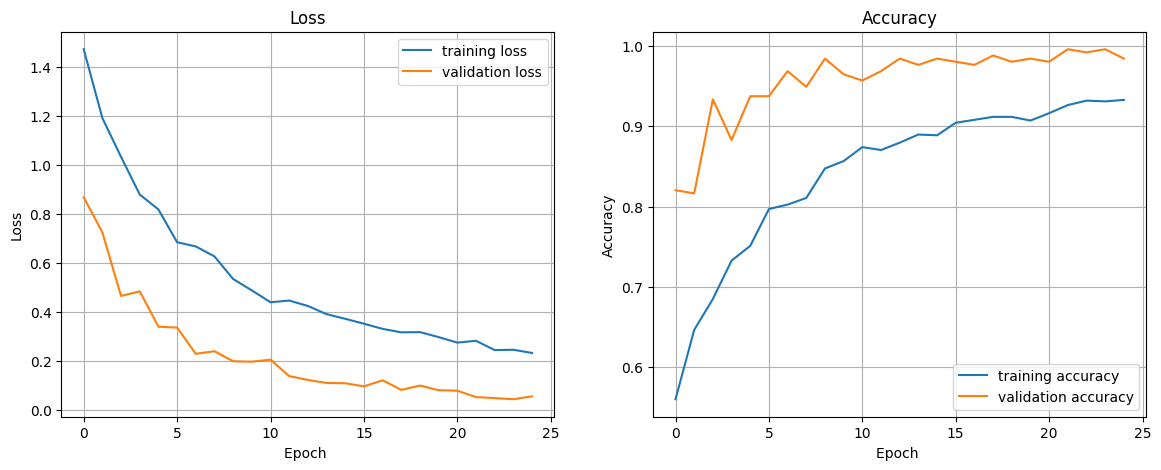

In [14]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(np.arange(0, numOfEpochs), H.history['loss'], label = 'training loss')
plt.plot(np.arange(0, numOfEpochs), H.history['val_loss'], label = 'validation loss')
plt.title("Loss")
plt.xlabel("Epoch ")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, numOfEpochs), H.history['accuracy'], label = 'training accuracy')
plt.plot(np.arange(0, numOfEpochs), H.history['val_accuracy'], label = 'validation accuracy')
plt.title("Accuracy")
plt.xlabel("Epoch ")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

4.2. Unfreeze some last CNN layers - VGG16 Model

In [15]:
for layer in baseModel.layers[15:]:
    layer.trainable = True

model.compile(optimizer= SGD(learning_rate=0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

numOfEpochs = 35
H = model.fit(x = create_infinite_generator(aug_train, X_train, y_train, 32),
              steps_per_epoch = len(X_train)//32,
              validation_data = create_infinite_generator(aug_test, X_train, y_train, 32),
              validation_steps = len(X_test)//32,
              epochs = numOfEpochs,
              verbose = 1)

Epoch 1/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 348ms/step - accuracy: 0.9550 - loss: 0.1691 - val_accuracy: 0.9961 - val_loss: 0.0176
Epoch 2/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 324ms/step - accuracy: 0.9580 - loss: 0.1393 - val_accuracy: 0.9961 - val_loss: 0.0213
Epoch 3/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 315ms/step - accuracy: 0.9580 - loss: 0.1472 - val_accuracy: 0.9961 - val_loss: 0.0171
Epoch 4/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 297ms/step - accuracy: 0.9726 - loss: 0.0999 - val_accuracy: 0.9922 - val_loss: 0.0193
Epoch 5/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 294ms/step - accuracy: 0.9689 - loss: 0.1054 - val_accuracy: 0.9961 - val_loss: 0.0142
Epoch 6/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 301ms/step - accuracy: 0.9667 - loss: 0.0949 - val_accuracy: 1.0000 - val_loss: 0.0088
Epoch 7/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 295ms/step - accuracy: 0.9585 - loss: 0.1071 - val_accuracy: 1.0000 - val_loss: 0.0139
Epoch 8/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 297ms/step - accuracy: 0.9808 - loss: 0.0700 - val_accu